# Лабораторная работа №4: Линейные модели, SVM и деревья решений.

**Цель лабораторной работы:** изучение линейных моделей, SVM и деревьев решений.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score 
from operator import itemgetter
from sklearn import tree

## Загрузка и первичный анализ данных

Для данной работы используем набор данных с характеристиками погодных условий: 

https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset

In [2]:
data = pd.read_csv('wind_dataset.csv')
data.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


В имеющихся данных 9 колонок и 6574 строки. В данных присутствуют пропуски. Согласно полученной документации:

* `DATE` : (YYYY-MM-DD)
* `WIND`: Средняя скорость ветра [в узлах]
* `IND`: Показатели с первого индикатора
* `RAIN`: Количество осадков (в мм)
* `IND.1`: Показатели с второго индикатора
* `T.MAX`: Максимальная температура (в °C)
* `IND.2`: Показатели с третьего индикатора
* `T.MIN`: Минимальная температура (в °C)
* `T.MIN.G`: минимальная температура травы в 09utc (в °C)

In [4]:
data.describe()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
count,6574.000000,6574.000000,6574.000000,6513.000000,5953.000000,6513.000000,5900.000000,6214.000000
mean,9.796834,0.391542,1.885169,0.356364,13.339123,0.464456,6.411678,2.736547
std,4.977272,1.179092,4.030529,1.128552,4.890546,1.177571,4.637243,5.569175
min,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,-11.500000,-14.400000
25%,6.000000,0.000000,0.000000,0.000000,9.600000,0.000000,3.000000,-1.000000
50%,9.210000,0.000000,0.200000,0.000000,13.300000,0.000000,6.500000,3.000000
75%,12.960000,0.000000,2.000000,0.000000,17.200000,0.000000,10.000000,7.000000
max,30.370000,4.000000,67.000000,4.000000,26.800000,4.000000,18.000000,15.800000


<AxesSubplot:>

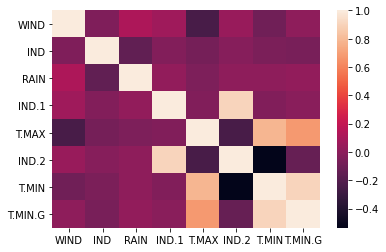

In [5]:
sns.heatmap(data.corr())

## Предобработка данных

### Преобразование дат

Переведем значения колонки **DATE** в сумму секунд, начиная с 1 янаваря 1970 года(согласно Unix time), что позволит представить дату, как непрерывную величину, что позволит применить к ней криетрий коррелякии Пирсона.

In [6]:
def date_to_unix(row):
    return (pd.Timestamp(row['DATE']).timestamp())

In [7]:
data['DATE'] = data.apply(date_to_unix, axis=1)

In [8]:
data.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,-283996800.0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,-283910400.0,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,-283824000.0,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,-283737600.0,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,-283651200.0,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


### Переименовывание колонок

Переведем названия колонок датасета в нижний регистр, для большего удобства

In [9]:
data.columns

Index(['DATE', 'WIND', 'IND', 'RAIN', 'IND.1', 'T.MAX', 'IND.2', 'T.MIN',
       'T.MIN.G'],
      dtype='object')

In [10]:
data.columns= data.columns.str.lower()

In [11]:
data.columns

Index(['date', 'wind', 'ind', 'rain', 'ind.1', 't.max', 'ind.2', 't.min',
       't.min.g'],
      dtype='object')

In [12]:
data = data.rename(columns={'ind.1':'ind_1',
                            't.max':'t_max',
                            'ind.2':'ind_2',
                            't.min' : 't_min',
                            't.min.g' : 't_min_g'})

In [13]:
data.columns

Index(['date', 'wind', 'ind', 'rain', 'ind_1', 't_max', 'ind_2', 't_min',
       't_min_g'],
      dtype='object')

### Обработка пропусков

Оценим количество пропусков в датасете

In [14]:
data.isna().sum()

date         0
wind         0
ind          0
rain         0
ind_1       61
t_max      621
ind_2       61
t_min      674
t_min_g    360
dtype: int64

Пропуски в колонках **t_min**, **t_max** и **t_min_g** занимают от 5 до 10 % записей в нашем датасете, удалять такое количество записей не самая лучшая практика, поэтому заполним пропуски в них медианным значением

In [15]:
data['t_max'] = data['t_max'].fillna(data['t_max'].median())
data['t_min'] = data['t_min'].fillna(data['t_min'].median())
data['t_min_g'] = data['t_min_g'].fillna(data['t_min_g'].median())

In [16]:
data.isna().sum()

date        0
wind        0
ind         0
rain        0
ind_1      61
t_max       0
ind_2      61
t_min       0
t_min_g     0
dtype: int64

Пропуски в оставшихся столбцах занимают по 1% от всего количества записей, поэтому можем спокойно их удалить

In [17]:
data = data.dropna(subset=['ind_1', 'ind_2']).reset_index(drop=True)

In [18]:
data.isna().sum()

date       0
wind       0
ind        0
rain       0
ind_1      0
t_max      0
ind_2      0
t_min      0
t_min_g    0
dtype: int64

От пропусков успешно избавились, теперь снова посмотрим на корреляции в данных

### Корреляции в данных

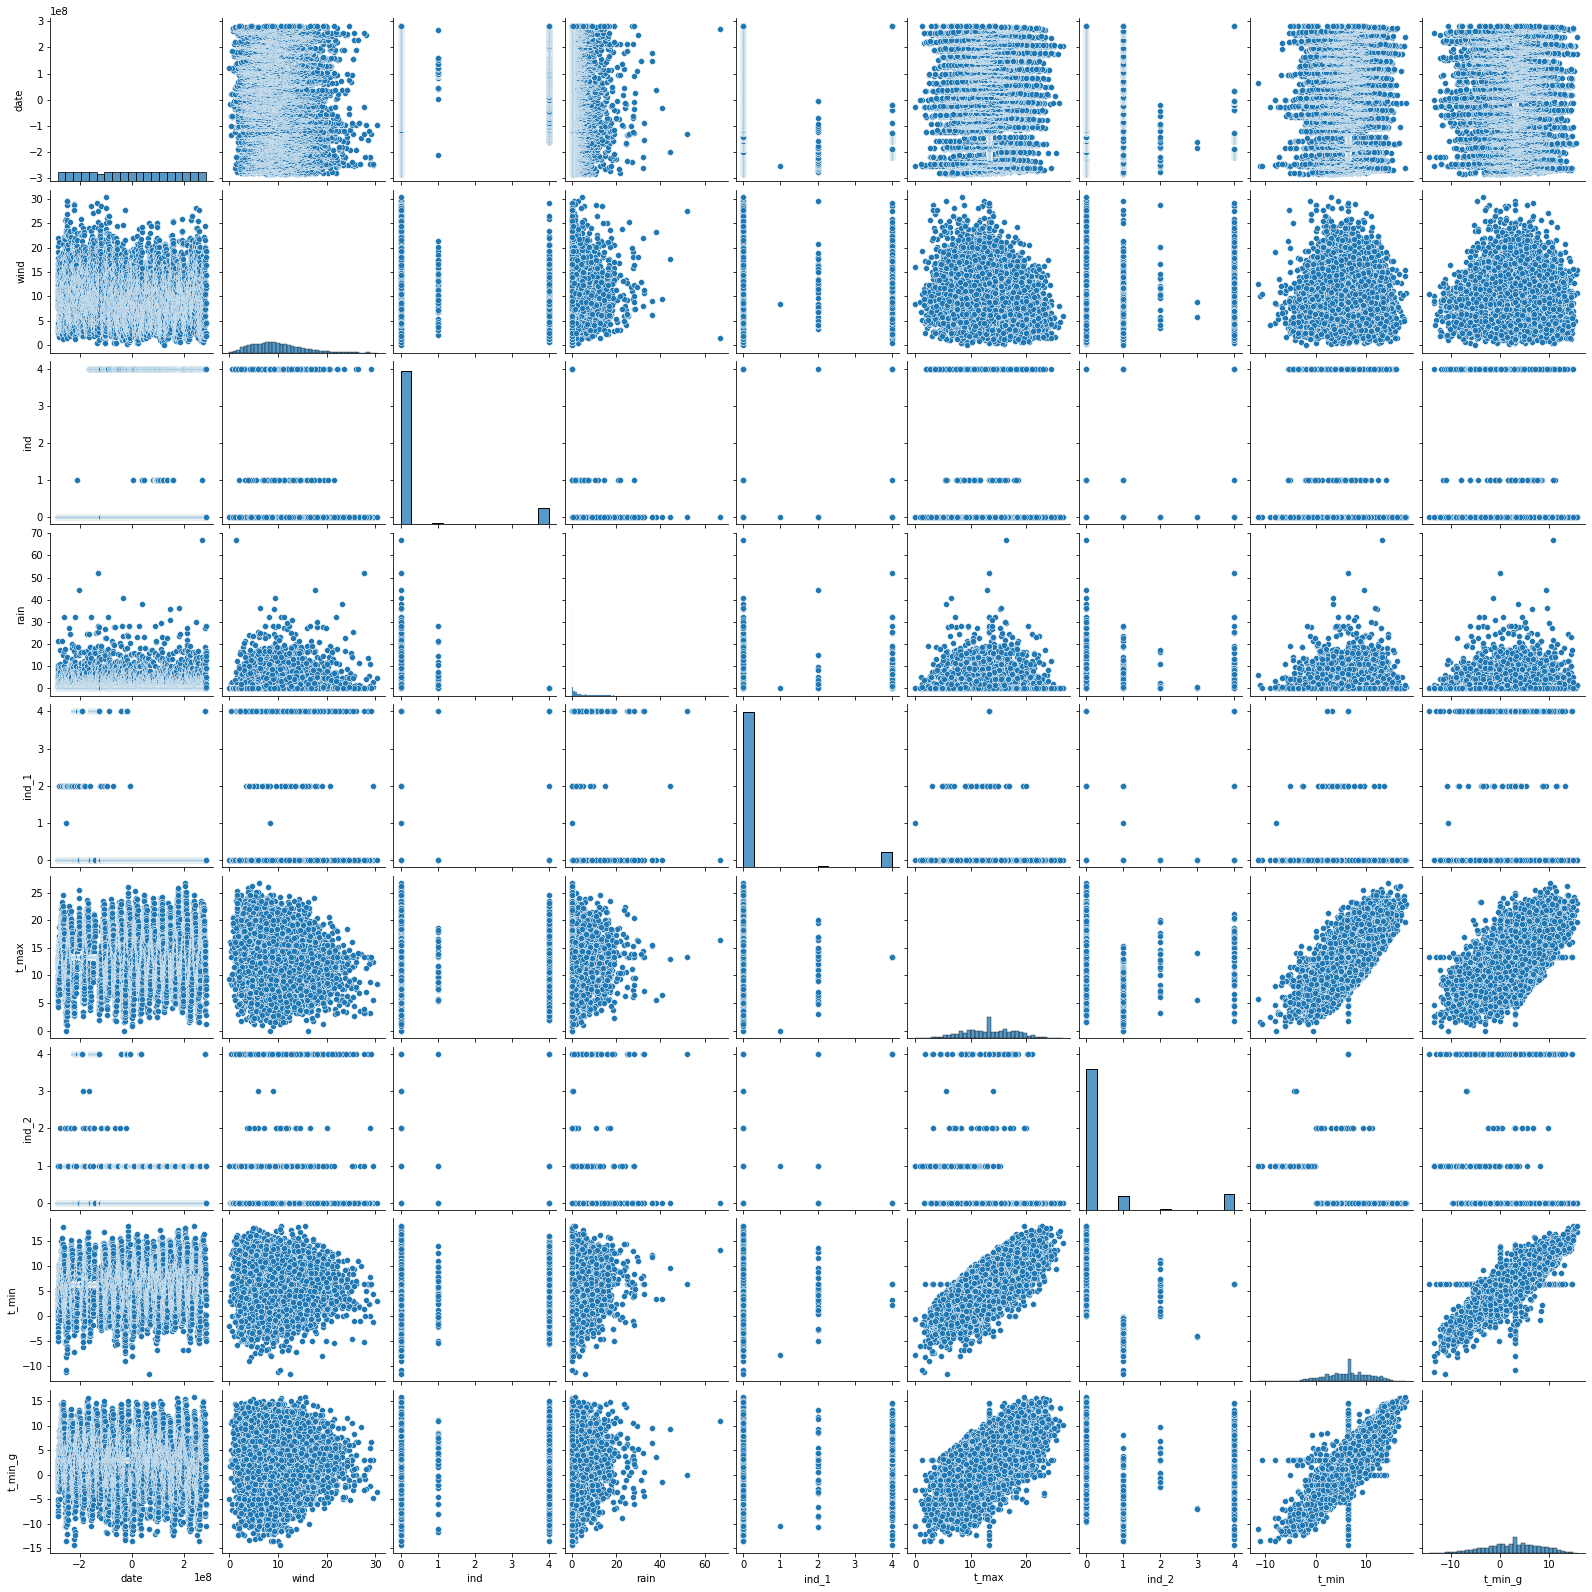

In [19]:
sns.pairplot(data)

<AxesSubplot:>

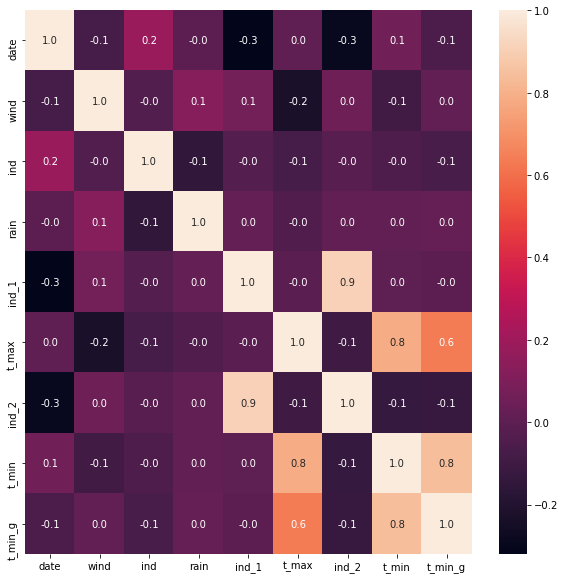

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt='.1f')

### Масштабирование данных

In [21]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['date', 'ind', 'rain', 'ind_1', 't_max', 'ind_2', 'ind_2', 't_min_g']])
sc2_data

array([[-1.73404899, -0.33284158, -0.41955692, ..., -0.39444863,
        -0.39444863, -0.68912908],
       [-1.73352333, -0.33284158,  0.80552119, ..., -0.39444863,
        -0.39444863, -0.30307691],
       [-1.73299766, -0.33284158, -0.36955373, ..., -0.39444863,
        -0.39444863, -0.5972119 ],
       ...,
       [ 1.72009365, -0.33284158,  3.20567422, ..., -0.39444863,
        -0.39444863,  0.08297526],
       [ 1.72061932, -0.33284158,  0.755518  , ..., -0.39444863,
        -0.39444863, -0.5972119 ],
       [ 1.72114498, -0.33284158, -0.34455214, ...,  0.45482209,
         0.45482209, -1.05679782]])

In [22]:
for i in range(0, 8):
    if i == 0:
        data['date'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 1:
        data['ind'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 2:
        data['rain'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 3:
        data['ind_1'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 4:
        data['t_max'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 5:
        data['ind_2'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 6:
        data['ind_2'] = pd.Series(sc2_data[:, i].tolist())
    elif i == 7:
        data['t_min_g'] = pd.Series(sc2_data[:, i].tolist())

In [23]:
data.head()

,date,wind,ind,rain,ind_1,t_max,ind_2,t_min,t_min_g
0,-1.734049,13.67,-0.332842,-0.419557,-0.315795,-0.820450,-0.394449,3.7,-0.689129
1,-1.733523,11.50,-0.332842,0.805521,-0.315795,-1.312408,-0.394449,4.2,-0.303077
2,-1.732998,11.25,-0.332842,-0.369554,-0.315795,-1.676029,-0.394449,0.5,-0.597212
3,-1.732472,8.63,-0.332842,-0.419557,-0.315795,-1.654640,-0.394449,0.4,-1.093565
4,-1.731946,11.92,-0.332842,2.130606,-0.315795,-1.312408,0.454822,-1.5,-1.884052


## Разделение данных на обучающую и тестовую выборки

In [24]:
features = data.drop('wind', axis=1)
target = data['wind']

In [25]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=1)

In [26]:
print(features_train.shape, features_test.shape)

(4884, 8) (1629, 8)


In [27]:
print(target_train.shape[0], target_test.shape[0])

4884 1629


## Обучение моделей

Обучим следующие модели:

- Линейную регрессию
- Метод опорных векторов
- Дерево решений

### Обучение модели линейной регрессии

In [28]:
model_LR = LinearRegression()

In [29]:
%%time
model_LR.fit(features_train, target_train)

Wall time: 6 ms


LinearRegression()

In [30]:
predictions_LR = model_LR.predict(features_test)

### Обучение модели метода опорных векторов

In [31]:
model_SVR = SVR()

In [32]:
%%time
model_SVR.fit(features_train, target_train)

Wall time: 1.16 s


SVR()

In [33]:
predictions_SVR = model_SVR.predict(features_test)

### Обучение модели дерева решений

In [34]:
model_DT = DecisionTreeRegressor(random_state=1, max_depth=3)

In [35]:
%%time
model_DT.fit(features_train, target_train)

Wall time: 6 ms


DecisionTreeRegressor(max_depth=3, random_state=1)

In [36]:
predictions_DT = model_DT.predict(features_test)

## Оценка качества полученных моделей

In [37]:
mae_dict = {}
mse_dict = {}
rmse_dict = {}
r2_dict = {}

In [38]:
mae_dict = {'Linear Regression' : mean_absolute_error(target_test, predictions_LR),
            'SVM' : mean_absolute_error(target_test, predictions_SVR),
            'Decision Tree' : mean_absolute_error(target_test, predictions_DT)}
mae_dict

{'Linear Regression': 3.691821407270074,
 'SVM': 3.5984271820508926,
 'Decision Tree': 3.5965270129246325}

In [39]:
mse_dict = {'Linear Regression' : mean_squared_error(target_test, predictions_LR),
            'SVM' : mean_squared_error(target_test, predictions_SVR),
            'Decision Tree' : mean_squared_error(target_test, predictions_DT)}
mse_dict

{'Linear Regression': 21.469374358686217,
 'SVM': 20.843766111626426,
 'Decision Tree': 20.77653213445396}

In [40]:
rmse_dict = {'Linear Regression' : mean_squared_error(target_test, predictions_LR, squared=False),
             'SVM' : mean_squared_error(target_test, predictions_SVR, squared=False),
             'Decision Tree' : mean_squared_error(target_test, predictions_DT, squared=False)}
rmse_dict

{'Linear Regression': 4.63350562303384,
 'SVM': 4.565497356436254,
 'Decision Tree': 4.5581281393192485}

In [41]:
r2_dict = {'Linear Regression' : r2_score(target_test, predictions_LR),
           'SVM' : r2_score(target_test, predictions_SVR),
           'Decision Tree' : r2_score(target_test, predictions_DT)}
r2_dict

{'Linear Regression': 0.11125882440340773,
 'SVM': 0.13715635637922374,
 'Decision Tree': 0.1399395582981059}

<BarContainer object of 3 artists>

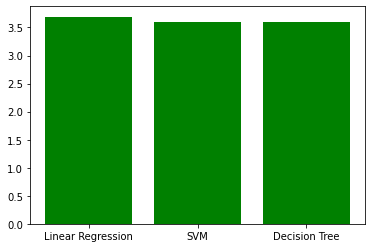

In [42]:
plt.bar(mae_dict.keys(), mae_dict.values(), color='g')

<BarContainer object of 3 artists>

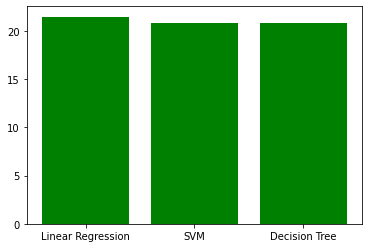

In [43]:
plt.bar(mse_dict.keys(), mse_dict.values(), color='g')

<BarContainer object of 3 artists>

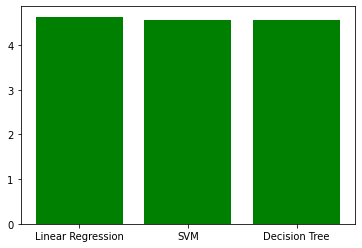

In [44]:
plt.bar(rmse_dict.keys(), rmse_dict.values(), color='g')

<BarContainer object of 3 artists>

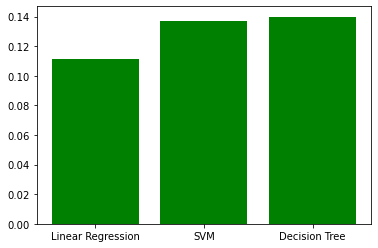

In [45]:
plt.bar(r2_dict.keys(), r2_dict.values(), color='g')

## Визуализция важности признаков для дерева решений

In [46]:
def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

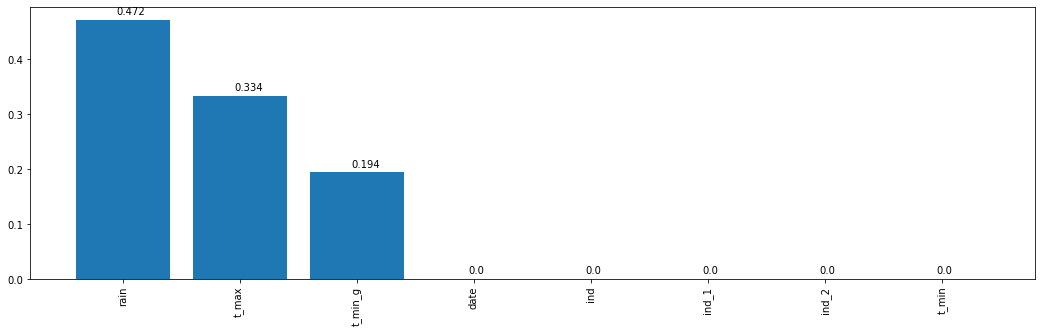

In [47]:
DT_label, DT_data = draw_feature_importances(model_DT, features_train)

## Визуализация дерева решений

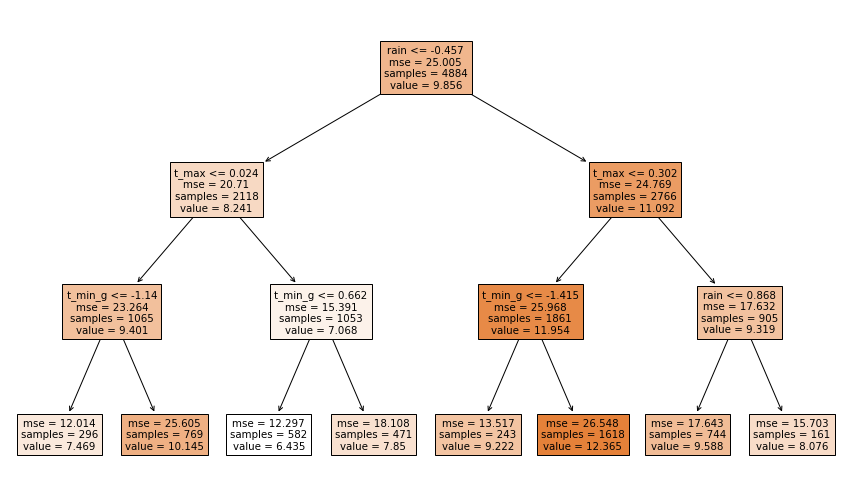

In [48]:
fig, axes = plt.subplots(figsize = (15,9))
tree.plot_tree(model_DT,
               feature_names = features_test.columns, 
               class_names='wind',
               filled = True);